In [114]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Data loading

In [115]:
names = ['end_timestamp', 'duration', 'src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol', 'flags', 'status', 'service_type', 'packets', 'bytes', 'label']

background = pd.read_csv("data/training/background_flows_cut.csv", header=None, names=names)
blacklist = pd.read_csv("data/training/blacklist_flows_cut.csv", header=None, names=names)
spam = pd.read_csv("data/training/spam_flows_cut.csv", header=None, names=names)
sshscan = pd.read_csv("data/training/sshscan_flows_cut.csv", header=None, names=names)

df = pd.concat([background, blacklist, spam, sshscan], ignore_index=True)
df.head()
df.bytes.max()

535517676

## Dataset Observations

In [116]:
print(f'Size of the dataset: {len(df)}\n')
print(f'Sumber of Nan values: {df.isnull().values.sum()}\n')
print(f'Column number: {len(df.columns)}\n')
print(f'Column names:\n{list(df.columns)}\n')
print('Column types:')
df.dtypes

Size of the dataset: 1477741

Sumber of Nan values: 0

Column number: 13

Column names:
['end_timestamp', 'duration', 'src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol', 'flags', 'status', 'service_type', 'packets', 'bytes', 'label']

Column types:


end_timestamp     object
duration         float64
src_ip            object
dst_ip            object
src_port           int64
dst_port           int64
protocol          object
flags             object
status             int64
service_type       int64
packets            int64
bytes              int64
label             object
dtype: object

#### Control of flows

In [117]:
print(f"Number of background exchanges : {len(df[df.label == 'background'])}")
print(f"Number of attack: {len(df[df.label != 'background'])}")
print(f"Number of blacklisted IP attack: {len(blacklist)}")
print(f"Number of ssh scan attack: {len(sshscan)}")
print(f"Number of spam attack: {len(spam)}")

Number of background exchanges : 477700
Number of attack: 1000041
Number of blacklisted IP attack: 500000
Number of ssh scan attack: 500000
Number of spam attack: 41


#### Numeric columns

In [118]:
numeric_df = df.select_dtypes(include=[np.int64, np.float64])
numeric_df.describe()

,duration,src_port,dst_port,status,service_type,packets,bytes
count,1.477741e+06,1.477741e+06,1.477741e+06,1477741.0,1.477741e+06,1.477741e+06,1.477741e+06
mean,3.232973e+00,2.207943e+04,2.014014e+04,0.0,1.018286e+01,1.541663e+01,8.853877e+03
std,1.253055e+01,2.373162e+04,2.351237e+04,0.0,1.808086e+01,6.634523e+02,6.518741e+05
min,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,1.000000e+00,2.700000e+01
25%,0.000000e+00,5.300000e+01,5.300000e+01,0.0,0.000000e+00,1.000000e+00,7.600000e+01
50%,3.880000e-01,8.082000e+03,4.450000e+02,0.0,0.000000e+00,7.000000e+00,1.105000e+03
75%,4.196000e+00,4.596800e+04,4.412500e+04,0.0,8.000000e+00,1.300000e+01,1.838000e+03
max,3.592160e+02,6.553500e+04,6.553500e+04,0.0,2.240000e+02,4.668150e+05,5.355177e+08


## Dataset Visualisation

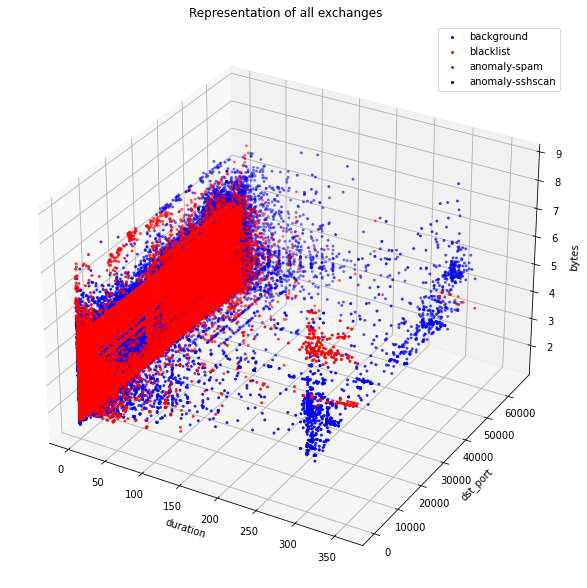

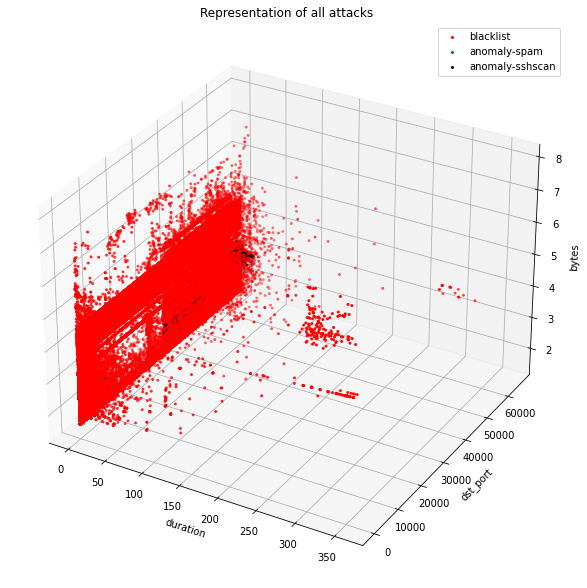

In [155]:
def show3D_flow_exchanges(df, x_axis, y_axis, z_axis, title):
    fig = plt.figure(figsize=(10,12))
    ax = fig.add_subplot(111, projection='3d')

    color = {
        'background': 'blue',
        'blacklist': 'red',
        'anomaly-spam': 'green',
        'anomaly-sshscan': 'black'
    }

    for label in df.label.unique():
        df_label = df[df.label == label]
        x = df_label[x_axis]
        y = df_label[y_axis]
        z = df_label[z_axis]
        ax.scatter(x, y, np.log10(z), color=color[label], label=label, marker='.', s=15)

    ax.set_xlabel(x_axis)
    ax.set_ylabel(y_axis)
    ax.set_zlabel(z_axis)
    ax.set_title(title)

    plt.legend()

show3D_flow_exchanges(df, 'duration', 'dst_port', 'bytes', 'Representation of all exchanges')
show3D_flow_exchanges(df[df.label != 'background'], 'duration', 'dst_port', 'bytes', 'Representation of all attacks')